In [1]:
import os
import numpy as np
import keras
import matplotlib.pyplot as plt

from skimage.transform import resize
from keras.models import Model
from keras import layers, models
from keras import backend as K

Using TensorFlow backend.


In [2]:
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

create_image_rows = 420
create_image_cols = 580

smooth = 1.0

In [3]:
image_t = np.load('./image_T.npy')
mask_t = np.load('./mask_T.npy')

suffle_seed = 42

In [4]:
train_image_rows = 96
train_image_cols = 96

def preprocess(imgs):
    imgs_p = np.ndarray(
        (imgs.shape[0], train_image_rows, train_image_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(
            imgs[i], (train_image_rows, train_image_cols), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p

In [5]:
image_c = preprocess(image_t)
mask_c = preprocess(mask_t)

image_c = image_c.astype('float32')

mean = np.mean(image_c)  # mean for data centering
std = np.std(image_c)  # std for data normalization

image_c -= mean
image_c /= 75

mask_c = mask_c .astype('float32')
mask_c /= 255.  # scale masks to [0, 1]

e:\program files\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
e:\program files\python36\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [6]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [7]:
def get_unet():
    inputs = layers.Input((train_image_rows, train_image_cols, 1))

    conv0_1 = layers.DepthwiseConv2D(32, 2, padding='same')(inputs)
    conv0_1 = layers.BatchNormalization()(conv0_1)
    conv0_1 = layers.Activation('relu')(conv0_1)
    conv0_2 = layers.Conv2D(32, 4, padding='same')(inputs)
    conv0_2 = layers.BatchNormalization()(conv0_2)
    conv0_2 = layers.Activation('relu')(conv0_2)
    pool0_1 = layers.MaxPool2D(pool_size=(2, 2))(conv0_2)
    pool0_1 = layers.Conv2D(1, 1, padding='same')(pool0_1)
    pool0_2 = layers.merge.add([conv0_1, pool0_1])

    conv1_1 = layers.DepthwiseConv2D(64, 2, padding='same')(pool0_2)
    conv1_1 = layers.BatchNormalization()(conv1_1)
    conv1_1 = layers.Activation('relu')(conv1_1)
    conv1_2 = layers.Conv2D(64, 4, padding='same')(pool0_2)
    conv1_2 = layers.BatchNormalization()(conv1_2)
    conv1_2 = layers.Activation('relu')(conv1_2)
    pool1_1 = layers.MaxPool2D(pool_size=(2, 2))(conv1_2)
    pool1_1 = layers.Conv2D(1, 1, padding='same')(pool1_1)
    pool1_2 = layers.merge.add([conv1_1, pool1_1])

    conv2_1 = layers.DepthwiseConv2D(128, 2, padding='same')(pool1_2)
    conv2_1 = layers.BatchNormalization()(conv2_1)
    conv2_1 = layers.Activation('relu')(conv2_1)
    conv2_2 = layers.Conv2D(128, 4, padding='same')(pool1_2)
    conv2_2 = layers.BatchNormalization()(conv2_2)
    conv2_2 = layers.Activation('relu')(conv2_2)
    pool2_1 = layers.MaxPool2D(pool_size=(2, 2))(conv2_2)
    pool2_1 = layers.Conv2D(1, 1, padding='same')(pool2_1)
    pool2_2 = layers.merge.add([conv2_1, pool2_1])

    conv3_1 = layers.DepthwiseConv2D(256, 2, padding='same')(pool2_2)
    conv3_1 = layers.BatchNormalization()(conv3_1)
    conv3_1 = layers.Activation('relu')(conv3_1)
    conv3_2 = layers.Conv2D(256, 4, padding='same')(pool2_2)
    conv3_2 = layers.BatchNormalization()(conv3_2)
    conv3_2 = layers.Activation('relu')(conv3_2)
    pool3_1 = layers.MaxPool2D(pool_size=(2, 2))(conv3_2)
    pool3_1 = layers.Conv2D(1, 1, padding='same')(pool3_1)
    pool3_2 = layers.merge.add([conv3_1, pool3_1])

    conv4 = layers.Conv2D(1, 5, activation='relu', padding='same')(pool3_2)
    conv4 = layers.Conv2D(1, 5, activation='relu', padding='same')(conv4)

    up5 = layers.Conv2DTranspose(128, 3, strides=(
        2, 2), activation='relu', padding='same')(conv4)
    merge5 = layers.concatenate([conv3_2, up5])
    conv5 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge5)
    conv5 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv5)

    up6 = layers.Conv2DTranspose(64, 3, strides=(
        2, 2), activation='relu', padding='same')(conv5)
    merge6 = layers.concatenate([conv2_2, up6])
    conv6 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(32, 3, strides=(
        2, 2), activation='relu', padding='same')(conv6)
    merge7 = layers.concatenate([conv1_2, up7])
    conv7 = layers.Conv2D(32, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(16, 3, strides=(
        2, 2), activation='relu', padding='same')(conv7)
    merge8 = layers.concatenate([conv0_2, up8])
    conv8 = layers.Conv2D(16, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(16, 3, activation='relu', padding='same')(conv8)

    conv8 = layers.Conv2D(1, 1, activation='sigmoid', padding='same')(conv8)

    model = Model(inputs=[inputs], outputs=[conv8])

    model.compile(optimizer=keras.optimizers.Adam(lr=0.00001),
                  loss=dice_coef_loss, metrics=[dice_coef])

    print((model.summary()))

    return model

In [8]:
unet = get_unet()
filepath = 'weights2.h5'
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True)

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 32)   544         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 96, 96, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 96, 96, 32)   0           batch_normalization_2[0][0]      
_____________________________________

In [14]:
image_train = image_c[0:1858]
image_valid = image_c[1858:]

mask_train = mask_c[0:1858]
mask_valid = mask_c[1858:]

In [10]:
print(('-'*30))
print('Fitting model...')
print(('-'*30))
from keras.callbacks import EarlyStopping, TensorBoard
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
tb_hist = TensorBoard(log_dir='./logs', 
                      histogram_freq=0, write_grads=True, write_images=True)

history = unet.fit(image_c,mask_c , epochs=200, verbose=1, shuffle=True,validation_split=0.15, 
                   batch_size=32,callbacks=[tb_hist,early_stopping,model_checkpoint])

print(('-'*30))
print('Done !!')
print(('-'*30))

------------------------------
Fitting model...
------------------------------
Train on 1974 samples, validate on 349 samples
Epoch 1/200
1974/1974 [==============================] - 27s 14ms/step - loss: -0.0565 - dice_coef: 0.0565 - val_loss: -0.0588 - val_dice_coef: 0.0588
Epoch 2/200
1974/1974 [==============================] - 4s 2ms/step - loss: -0.0585 - dice_coef: 0.0585 - val_loss: -0.0617 - val_dice_coef: 0.0617
Epoch 3/200
1974/1974 [==============================] - 4s 2ms/step - loss: -0.0626 - dice_coef: 0.0626 - val_loss: -0.0702 - val_dice_coef: 0.0702
Epoch 4/200
1974/1974 [==============================] - 4s 2ms/step - loss: -0.0746 - dice_coef: 0.0746 - val_loss: -0.0878 - val_dice_coef: 0.0878
Epoch 5/200
1974/1974 [==============================] - 4s 2ms/step - loss: -0.0900 - dice_coef: 0.0900 - val_loss: -0.1029 - val_dice_coef: 0.1029
Epoch 6/200
1974/1974 [==============================] - 4s 2ms/step - loss: -0.1049 - dice_coef: 0.1049 - val_loss: -0.1184 - 

In [10]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    zca_whitening=True,
    zca_epsilon=0.99,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=10,
    fill_mode='reflect',
    horizontal_flip=True)

mask_datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=10,
    fill_mode='reflect',
    horizontal_flip=True)

test_datagen = keras.preprocessing.image.ImageDataGenerator()

In [11]:
train_datagen.fit(image_c, augment=True, seed=1)

print(('='*30))
print('Done train fit')
print(('='*30))

mask_datagen.fit(mask_c, augment=True, seed=1)

print(('='*30))
print('Done mask fit')
print(('='*30))

Done train fit
Done mask fit


In [13]:
unet = get_unet()
filepath = 'weights2.h5'
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 96, 96, 32)   544         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 96, 96, 32)   128         conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 96, 96, 32)   0           batch_normalization_10[0][0]     
__________________________________________________________________________________________________
depthwise_

In [15]:
train_data = train_datagen.flow(image_train, mask_train,batch_size=32,seed=suffle_seed )
valid_data = test_datagen.flow(image_valid, mask_valid,batch_size=32,seed=suffle_seed )

In [16]:
train_img = np.zeros([10240,96,96,1])
train_msk = np.zeros([10240,96,96,1])

In [17]:
i = 0
for batch in train_datagen.flow(image_c, batch_size=1, seed=suffle_seed):
    train_img[i] = batch
    i += 1
    if i < 10239 and i % 1000 == 1:
        print('Done train_img = {}'.format(i-1))
    elif i > 10239:
        break

#np.save('/content/gdrive/My Drive/Colab Notebooks/img_aug', train_img)
print(('-'*30))
print('Done train fit')
print(('-'*30))

i = 0
for batch in test_datagen.flow(mask_c, batch_size=1, seed=suffle_seed):
    train_msk[i] = batch
    i += 1
    if i < 10239 and i % 1000 == 1:
        print('Done train_mask = {}'.format(i-1))
    elif i > 10239:
        break

#np.save('/content/gdrive/My Drive/Colab Notebooks/mask_aug', train_msk)
print(('-'*30))
print('Done test fit')
print(('-'*30))

Done train_img = 0
Done train_img = 1000
Done train_img = 2000
Done train_img = 3000
Done train_img = 4000
Done train_img = 5000
Done train_img = 6000
Done train_img = 7000
Done train_img = 8000
Done train_img = 9000
Done train_img = 10000
------------------------------
Done train fit
------------------------------
Done train_mask = 0
Done train_mask = 1000
Done train_mask = 2000
Done train_mask = 3000
Done train_mask = 4000
Done train_mask = 5000
Done train_mask = 6000
Done train_mask = 7000
Done train_mask = 8000
Done train_mask = 9000
Done train_mask = 10000
------------------------------
Done test fit
------------------------------


In [18]:
del image_t
del mask_t

In [19]:
from keras.callbacks import EarlyStopping, TensorBoard
print(('-'*30))
print('Fitting model...')
print(('-'*30))
early_stopping = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
tb_hist = TensorBoard(log_dir='./logs',
                      histogram_freq=0, write_grads=True, write_images=True)

history = unet.fit(train_img, train_msk, epochs=200, verbose=1, shuffle=True, validation_split=0.15,
                   batch_size=32, callbacks=[tb_hist, early_stopping, model_checkpoint])

print(('-'*30))


print('Done !!')
print(('-'*30))

------------------------------
Fitting model...
------------------------------
Train on 8704 samples, validate on 1536 samples
Epoch 1/200
8704/8704 [==============================] - 26s 3ms/step - loss: -0.0612 - dice_coef: 0.0612 - val_loss: -0.0796 - val_dice_coef: 0.0796
Epoch 2/200
8704/8704 [==============================] - 20s 2ms/step - loss: -0.1258 - dice_coef: 0.1258 - val_loss: -0.2827 - val_dice_coef: 0.2827
Epoch 3/200
8704/8704 [==============================] - 20s 2ms/step - loss: -0.4189 - dice_coef: 0.4189 - val_loss: -0.4462 - val_dice_coef: 0.4462
Epoch 4/200
8704/8704 [==============================] - 20s 2ms/step - loss: -0.4500 - dice_coef: 0.4500 - val_loss: -0.4575 - val_dice_coef: 0.4575
Epoch 5/200
8704/8704 [==============================] - 20s 2ms/step - loss: -0.4582 - dice_coef: 0.4582 - val_loss: -0.4599 - val_dice_coef: 0.4599
Epoch 6/200
8704/8704 [==============================] - 20s 2ms/step - loss: -0.4633 - dice_coef: 0.4633 - val_loss: -0.46

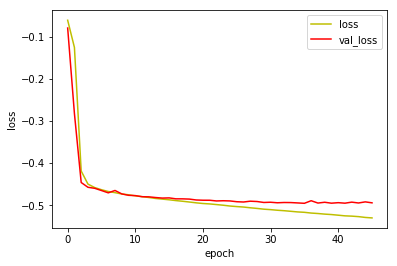

In [20]:
plt.plot(history.history['loss'], 'y', label='loss')
plt.plot(history.history['val_loss'], 'r', label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

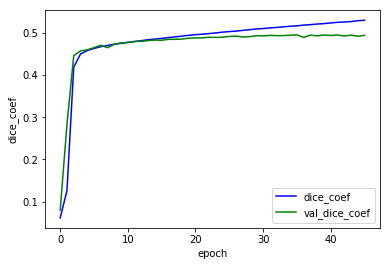

In [21]:
plt.plot(history.history['dice_coef'], 'b', label='dice_coef')
plt.plot(history.history['val_dice_coef'], 'g', label='val_dice_coef')
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.legend(loc='lower right')
plt.show()

In [22]:
import pandas as pd

df = pd.DataFrame({"loss": history.history['loss'],  "val_loss": history.history['val_loss'],
                   "dice_coef": history.history['dice_coef'],  "val_dice_coef": history.history['val_dice_coef'], })
df.to_csv('./history_{:2.2}.csv'.format(history.history['val_dice_coef'][-1]))
unet.save_weights("./model_{:2.2}.h5".format(history.history['val_dice_coef'][-1]))

In [24]:
import cv2

mask_predict = unet.predict(image_valid, verbose=1)
score = unet.evaluate(mask_predict, mask_valid , verbose=1)

465/465 [==============================] - 0s 776us/step


In [25]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: -0.43068164260156694
Test accuracy: 0.43068164260156694


In [26]:
mask_r = mask_predict.reshape(465, 96, 96)
mask_test_u = mask_valid.reshape(465, 96, 96)
image_test_u = image_valid.reshape(465, 96, 96)

In [27]:
img_test_o = (mask_r*2)+image_test_u
img_predict_o =image_test_u+(mask_test_u*2)

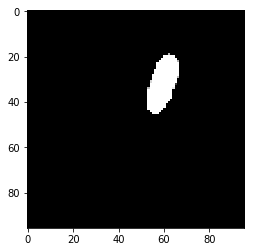

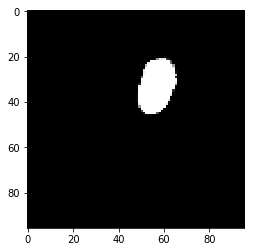

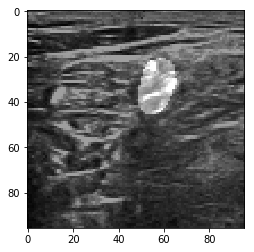

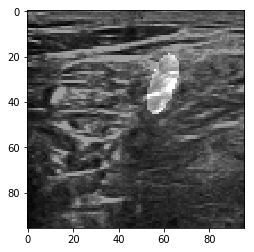

In [28]:
plt.figure()
plt.imshow(mask_test_u[35], cmap='gray')
plt.show()

plt.figure()
plt.imshow( mask_r[35], cmap='gray')
plt.show()

plt.figure()
plt.imshow(img_test_o[35], cmap='gray')
plt.show()

plt.figure()
plt.imshow(img_predict_o[35], cmap='gray')
plt.show()